In [1]:
%pylab inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.cross_validation import StratifiedKFold

# === Parameter tuning - Using Hyperopt ===
from hyperopt import hp, fmin, tpe
from time import time

In [3]:
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns

In [4]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

In [5]:
del train['id']

In [6]:
# prepare data for hyperopt
X_train = train.drop(['target'], axis = 1)
y_train = train.target
y_train = y_train.astype('str')
y_train = y_train.apply(lambda x: int(x.replace('Class_', '')) )
y_train = y_train - 1   # need to start from 0

In [7]:
y_train[:5]

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [8]:
X_train.values[:2]

array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  2,
         0,  0,  0,  0,  1,  0,  4,  1,  1,  0,  0,  2,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  1,  0,  5,  0,  0,  0,  0,  0,  2,  0,  0,  0,
         0,  0,  1,  0,  0,  2,  0,  0, 11,  0,  1,  1,  0,  1,  0,  7,  0,
         0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0,  0,  1,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,
         0,  0,  0,  0,  2,  1,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

# General Parameter Tuning

In [39]:
space = (
    hp.choice( 'subsample', np.arange(0.2, 1.2, step=0.2)),
    hp.choice( 'max_depth', np.arange(6, 18, step=2) ),
    hp.choice( 'min_child_weight', np.arange(4, 20, step=4) )
)

In [17]:
# test interactions    
N = y_train.values.shape[0]
folds = 5
ntree = 100

depthparams = np.arange(14, 32, step=2)
X = X_train.values
y = y_train.values
    
for depth in depthparams:
    kf = KFold(N, n_folds=folds, shuffle=True)
     
    print "depth : %r " %depth
    train_cv_error = np.empty( folds ) 
    test_cv_error  = np.empty( folds )

    params = {'max_depth': depth,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.1, 
              'min_child_weight': 4,
               # 'colsample_bytree': 1.0,   # column subsample
              'subsample': 0.6,           # row subsample
              'num_class': 9,
              'silent': False
              }

    s = time()
    
    index = 0
    for train_index, test_index in kf:
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
    
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dtest  = xgb.DMatrix(X_test_cv)
        
        xgb_fit = xgb.train(params, dtrain = dtrain, num_boost_round = ntree)
        train_cv_error[index] = log_loss( y_train_cv, xgb_fit.predict(dtrain) ) 
        test_cv_error[index]  = log_loss( y_test_cv, xgb_fit.predict(dtest) ) 
        index = index + 1

    train_error = np.mean(train_cv_error)
    test_error  = np.mean(test_cv_error)
    print "Test error: %r" % test_error
    print "Train error: %r " % train_error
    print "elapsed: {}s \n".format( int( round( time() - s )))

depth : 14 
Test error: 0.48240473102322118
Train error: 0.20355923537738924 
elapsed: 111s 

depth : 16 
Test error: 0.48070314551439025
Train error: 0.17951230139168173 
elapsed: 119s 

depth : 18 
Test error: 0.47767083022158141
Train error: 0.15969442724298238 
elapsed: 126s 

depth : 20 
Test error: 0.47701688612478821
Train error: 0.14637431095626086 
elapsed: 132s 

depth : 22 
Test error: 0.47672521987528621
Train error: 0.1366504083067043 
elapsed: 137s 

depth : 24 
Test error: 0.47675341479774469
Train error: 0.12776892654743049 
elapsed: 140s 

depth : 26 
Test error: 0.47834007879081408
Train error: 0.1218192076181138 
elapsed: 144s 

depth : 28 
Test error: 0.47830127521433152
Train error: 0.11779512333586924 
elapsed: 147s 

depth : 30 
Test error: 0.47856912685843855
Train error: 0.11449644673841113 
elapsed: 149s 



# Class Weights

In [101]:
train.target.value_counts()

Class_2    16122
Class_6    14135
Class_8     8464
Class_3     8004
Class_9     4955
Class_7     2839
Class_5     2739
Class_4     2691
Class_1     1929
dtype: int64

In [108]:
# use weights inversely proportional to #items in each class
freq = train.target.value_counts().values

In [109]:
weights = sum(freq) * 1.0 / freq

In [111]:
weights

array([  3.83810942,   4.37764415,   7.31072779,   7.73088456,
        12.48799193,  21.79570271,  22.59145674,  22.99442586,  32.0777605 ])

In [112]:
weights = [32.0777605, 3.83810942, 7.73088456, 22.99442586, 22.59145674, 4.37764415, 
           21.79570271, 7.31072779, 12.48799193]

In [33]:
params_m14 = {'max_depth': 14,
             'objective': 'multi:softprob',
             'eval_metric': 'mlogloss',
             'learning_rate': 0.02, 
             'min_child_weight': 6,
             'colsample_bytree': 0.5,   # column subsample
             'subsample': 0.8,           # row subsample
             'gamma': 0.0,
             'num_class': 9,
             # 'scale_pos_weight': weights,
             'seed': 26,
             'silent': False
            }

In [34]:
xgb_m14 = xgb.cv(params_m14, xgb.DMatrix(np.sqrt(3.0/8 + X_train.values), label=y_train), num_boost_round = 5000, nfold=5)

[0]	cv-test-mlogloss:2.153496+0.002049	cv-train-mlogloss:2.151741+0.002029
[1]	cv-test-mlogloss:2.112135+0.002244	cv-train-mlogloss:2.108694+0.002402
[2]	cv-test-mlogloss:2.073079+0.003294	cv-train-mlogloss:2.068149+0.003461
[3]	cv-test-mlogloss:2.034662+0.002794	cv-train-mlogloss:2.028015+0.003215
[4]	cv-test-mlogloss:1.998898+0.002718	cv-train-mlogloss:1.990591+0.002890
[5]	cv-test-mlogloss:1.963548+0.001938	cv-train-mlogloss:1.953678+0.001915
[6]	cv-test-mlogloss:1.931355+0.001678	cv-train-mlogloss:1.919949+0.001712
[7]	cv-test-mlogloss:1.899194+0.001806	cv-train-mlogloss:1.886298+0.001335
[8]	cv-test-mlogloss:1.869343+0.002660	cv-train-mlogloss:1.855161+0.002041
[9]	cv-test-mlogloss:1.840315+0.002862	cv-train-mlogloss:1.824805+0.002787
[10]	cv-test-mlogloss:1.811788+0.002196	cv-train-mlogloss:1.794948+0.002220
[11]	cv-test-mlogloss:1.784949+0.003033	cv-train-mlogloss:1.766670+0.002769
[12]	cv-test-mlogloss:1.759215+0.002351	cv-train-mlogloss:1.739569+0.002357
[13]	cv-test-mlogloss:

KeyboardInterrupt: 

In [148]:
# reduce learning_rate
params_m14 = {'max_depth': 14,
             'objective': 'multi:softprob',
             'eval_metric': 'mlogloss',
             'learning_rate': 0.01, 
             'min_child_weight': 6,
             'colsample_bytree': 0.5,   # column subsample
             'subsample': 0.8,           # row subsample
             'num_class': 9,
             'nthread': 16,
             'seed': 26,
             'silent': False
            }

In [149]:
xgb_m14 = xgb.cv(params_m14, xgb.DMatrix(np.sqrt(3.0/8 + X_train.values), label=y_train), num_boost_round = 10000, nfold=5)

[0]	cv-test-mlogloss:2.175298+0.001028	cv-train-mlogloss:2.174420+0.001016
[1]	cv-test-mlogloss:2.153987+0.001161	cv-train-mlogloss:2.152260+0.001255
[2]	cv-test-mlogloss:2.132751+0.001435	cv-train-mlogloss:2.130218+0.001290
[3]	cv-test-mlogloss:2.112448+0.001431	cv-train-mlogloss:2.109148+0.001526
[4]	cv-test-mlogloss:2.092278+0.001599	cv-train-mlogloss:2.088241+0.001575
[5]	cv-test-mlogloss:2.073162+0.001857	cv-train-mlogloss:2.068229+0.001752
[6]	cv-test-mlogloss:2.054187+0.002068	cv-train-mlogloss:2.048485+0.001938
[7]	cv-test-mlogloss:2.036024+0.002394	cv-train-mlogloss:2.029446+0.002579
[8]	cv-test-mlogloss:2.018539+0.002618	cv-train-mlogloss:2.011125+0.002690
[9]	cv-test-mlogloss:2.001040+0.002350	cv-train-mlogloss:1.992802+0.002653
[10]	cv-test-mlogloss:1.983642+0.002835	cv-train-mlogloss:1.974719+0.002913
[11]	cv-test-mlogloss:1.966613+0.003021	cv-train-mlogloss:1.956958+0.003036
[12]	cv-test-mlogloss:1.949552+0.003467	cv-train-mlogloss:1.939200+0.003419
[13]	cv-test-mlogloss:

KeyboardInterrupt: 

In [80]:
params_m8 = {'max_depth': 8, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss',
             'learning_rate': 0.1, 'min_child_weight': 5,
             'colsample_bytree': 0.4426, 'subsample': 0.7809,         
             'seed': 26, 'nthread': 16, 'num_class': 9 }

In [81]:
xgb_m8 = xgb.cv(params_m8, xgb.DMatrix(np.sqrt(3.0/8 + X_train.values), label=y_train), num_boost_round = 5000, nfold=5)

[0]	cv-test-mlogloss:2.009434+0.012919	cv-train-mlogloss:2.004455+0.013099
[1]	cv-test-mlogloss:1.859748+0.012195	cv-train-mlogloss:1.851067+0.013034
[2]	cv-test-mlogloss:1.734930+0.010524	cv-train-mlogloss:1.722525+0.011468
[3]	cv-test-mlogloss:1.630878+0.010921	cv-train-mlogloss:1.615376+0.010306
[4]	cv-test-mlogloss:1.542852+0.011039	cv-train-mlogloss:1.524382+0.010218
[5]	cv-test-mlogloss:1.464810+0.010167	cv-train-mlogloss:1.443400+0.009566
[6]	cv-test-mlogloss:1.396325+0.005866	cv-train-mlogloss:1.372292+0.006389
[7]	cv-test-mlogloss:1.336521+0.005145	cv-train-mlogloss:1.310012+0.006685
[8]	cv-test-mlogloss:1.280240+0.004121	cv-train-mlogloss:1.251482+0.004258
[9]	cv-test-mlogloss:1.231110+0.007009	cv-train-mlogloss:1.200083+0.004349
[10]	cv-test-mlogloss:1.186157+0.007755	cv-train-mlogloss:1.153231+0.005863
[11]	cv-test-mlogloss:1.143633+0.007629	cv-train-mlogloss:1.108687+0.005324
[12]	cv-test-mlogloss:1.106175+0.007841	cv-train-mlogloss:1.069413+0.005406
[13]	cv-test-mlogloss:

KeyboardInterrupt: 

In [115]:
xgb_m14 = xgb.train(params_m14, xgb.DMatrix(X_train, label=y_train), num_boost_round = 1190)

In [123]:
predicted = xgb_m14.predict( xgb.DMatrix(X_train) )

In [124]:
predicted[:5]

array([[  7.63675511e-01,   1.62477227e-04,   1.81342199e-04,
          8.72454606e-04,   4.36890914e-05,   2.24102050e-01,
          2.60299956e-03,   4.80077555e-03,   3.55869625e-03],
       [  4.62497890e-01,   1.11218989e-02,   7.95584172e-03,
          2.60047149e-03,   4.32732701e-03,   2.32715271e-02,
          3.28548625e-02,   4.42272037e-01,   1.30981980e-02],
       [  8.85272443e-01,   6.01980276e-03,   1.84342952e-03,
          6.69069239e-04,   1.01228582e-03,   1.12246247e-02,
          2.61626020e-02,   1.72827300e-02,   5.05130291e-02],
       [  9.79961872e-01,   4.94460284e-04,   3.87079665e-04,
          1.22198151e-04,   6.06533285e-06,   2.22447515e-03,
          7.25389319e-03,   9.28517710e-03,   2.64787843e-04],
       [  8.58509660e-01,   5.98679064e-04,   9.30543232e-04,
          2.54436658e-04,   2.33400933e-04,   1.23924613e-02,
          7.15152025e-02,   5.11708818e-02,   4.39475151e-03]], dtype=float32)

**DOESN'T WORK YET**

#Blending xgboost and RF

In [9]:
kf = StratifiedKFold(y_train.values, n_folds=5, shuffle=False, random_state=26)

In [95]:
fold = 1

# read the data
predicted_m8  = pd.read_csv("xgboost_blend/predicted_m8_fold" + str(fold) + ".csv")
predicted_m14 = pd.read_csv("xgboost_blend/predicted_m14_fold" + str(fold) + ".csv")
predicted_m20 = pd.read_csv("xgboost_blend/predicted_m20_fold" + str(fold) + ".csv")

predicted_rf36 = pd.read_csv("rf_blend/predicted_RF_depth36_fold" + str(fold) + ".csv")
predicted_rf38 = pd.read_csv("rf_blend/predicted_RF_depth38_fold" + str(fold) + ".csv")
predicted_rf40 = pd.read_csv("rf_blend/predicted_RF_depth40_fold" + str(fold) + ".csv")

# use old blend 50
predicted_h2o_1  = pd.read_csv("h2o_blend/50/predicted_h2o_" + str(fold) + ".csv")
predicted_h2o_2  = pd.read_csv("h2o_blend/100/predicted_h2o_" + str(fold) + ".csv")

# read the test cv
for index, (train_index, test_index) in enumerate(kf):
    if index == fold:
        X_train_cv, X_test_cv = X_train.values[train_index], X_train.values[test_index]
        y_train_cv, y_test_cv = y_train.values[train_index], y_train.values[test_index]

In [96]:
# add in xgb biased 
xgb_m1 = pd.read_csv("biased_xgb/xgb_m1_f" + str(fold) + ".csv")
xgb_m2 = pd.read_csv("biased_xgb/xgb_m2_f" + str(fold) + ".csv")
xgb_m3 = pd.read_csv("biased_xgb/xgb_m3_f" + str(fold) + ".csv")
xgb_m4 = pd.read_csv("biased_xgb/xgb_m4_f" + str(fold) + ".csv")
xgb_m5 = pd.read_csv("biased_xgb/xgb_m5_f" + str(fold) + ".csv")
xgb_m6 = pd.read_csv("biased_xgb/xgb_m6_f" + str(fold) + ".csv")
xgb_m7 = pd.read_csv("biased_xgb/xgb_m7_f" + str(fold) + ".csv")
xgb_m8 = pd.read_csv("biased_xgb/xgb_m8_f" + str(fold) + ".csv")

In [97]:
w1 = 1.7    # 0.463541
w2 = 1.8    # 0.467150
w3 = 0.9    # 0.494256
w4 = 1.1    # 0.485766
w5 = 2.3    # 0.469556
w6 = 0.4    # 0.490782
w7 = 3.0    # 0.464772
w8 = 2.0    # 0.474028

predicted_xgblend = (w1 * xgb_m1 + w2 * xgb_m2 + w3 * xgb_m3 + w4 * xgb_m4 + w5 * xgb_m5 + w6 * xgb_m6 
             + w7 * xgb_m7 + w8 * xgb_m8) / (w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8)

log_loss( y_test_cv, predicted_xgblend.values )

0.45628800464656594

In [114]:
w8  = 0.0
w14 = 1.0
w20 = 1.2

predicted_xgb = (w8*predicted_m8 + w14*predicted_m14 + w20*predicted_m20) / (w8 + w14 + w20)
log_loss( y_test_cv, predicted_xgb.values )

# 0.45263785003040857

0.45262886228107035

In [115]:
print "m8 loss: ", log_loss( y_test_cv, predicted_m8.values)
print "m14 loss: ", log_loss( y_test_cv, predicted_m14.values)
print "m20 loss: ", log_loss( y_test_cv, predicted_m20.values)

m8 loss:  0.490846020976
m14 loss:  0.454017749976
m20 loss:  0.453586021189


In [15]:
xgb_loss = [0.44948093799051336, 0.45263785003040857, 0.44275265097005057, 0.43681261125266113, 0.44319910781203831]
mean(xgb_loss)

0.44497663161113438

In [119]:
print "rf36 : ", log_loss( y_test_cv, predicted_rf36.drop("Unnamed: 0", axis=1).values)
print "rf38 : ", log_loss( y_test_cv, predicted_rf38.drop("Unnamed: 0", axis=1).values)
print "rf40 : ", log_loss( y_test_cv, predicted_rf40.drop("Unnamed: 0", axis=1).values)

rf36 :  0.493992719465
rf38 :  0.490049655825
rf40 :  0.490263532873


In [141]:
rf36 = 0.7
rf38 = 0.7
rf40 = 1.1

predicted_rf = (rf36 * predicted_rf36 + rf38 * predicted_rf38 
                + rf40 * predicted_rf40) / (rf36 + rf38 + rf40)

predicted_rf = predicted_rf.drop("Unnamed: 0", axis=1)
log_loss( y_test_cv, predicted_rf.values)

0.48744865564539452

In [24]:
# h2o
print "h2o 1: ", log_loss( y_test_cv, predicted_h2o_1.values)
print "h2o 2: ", log_loss( y_test_cv, predicted_h2o_2.values)

h2o 1:  0.459833625638
h2o 2:  0.446704959674


In [94]:
w_h1 = 0.1
w_h2 = 1.0

predicted_h2o = (w_h1 * predicted_h2o_1 + w_h2 * predicted_h2o_2) / (w_h1 + w_h2)

log_loss( y_test_cv, predicted_h2o.values )

0.44664347863533627

In [154]:
# combine loss
w_rf = 0.3
w_xgb = 3.7
w_h2o_1 = 0.0
w_h2o_2 = 3.1
w_xgb_b = 0.0  # xgb biased subspace

predicted = ( w_xgb * predicted_xgb + w_rf * predicted_rf 
             + w_h2o_2 * predicted_h2o_2.values + w_h2o_1 * predicted_h2o_1.values
            + w_xgb_b * predicted_xgblend) / (w_xgb + w_rf + w_h2o_1 + w_h2o_2 + w_xgb_b)

log_loss( y_test_cv, predicted.values)

0.43475179043071133

    with h2o old and new
    fold 0
    0.6 4.0 -1.0 3.1 -0.7: 0.43007176040836809
    0.6 4.0 -1.0 3.1 -0.9: 0.43005259001728385
    0.6 3.7 -1.0 3.1 -0.9: 0.43002699612920969 --> current BEST

    fold 1
    0.6 3.7 -1.0 3.1 -0.9: 0.43598217475978834

    fold 0
    1 4 1 : 0.43967098348401246
    1 4 2 : 0.43732976654584271
    1 4 3 : 0.43665713538623768  !!!
    1 4 4 : 0.4367165535564006
    1 4 5 : 0.43712056751432171

    0.7 4 3 : 0.43648967326695126
    0.6 4 3 : 0.43646828361210566  !!! 
    0.5 4 3 : 0.4364686365808329
    0.4 4 3 : 0.43649448190845369

    0.6 4 3.5 : 0.43652131041613723
    0.6 4 2.5 : 0.43658906399432107
    0.6 4 3.1 : 0.43646721606663813  --> BEST

    fold 1
    0.6 4 3.1 : 0.44002214833291453
    0.5 4 3.1 : 0.43999728216946071
    0.4 4 3.1 : 0.43999462577360715
    0.3 4 3.1 : 0.44001791373647559
    
    with xgb biased
    fold 0
    0.6 4 3.1 1.0 : 0.43693483828810542
    fold 1
    0.6 4 3.1 0.1 : 0.44005733041097828 
    
    with new h2o - improves 0.06 compared to previous scores
    fold 0
    0.6 4 3.1 : 0.43075817465796679
    0.6 4 3.3 : 0.43074777715083451
    0.6 4 2.9 : 0.43079630783580025
    
    fold 1:
    0.6 4 3.3 : 0.43477948725911952
    0.6 4 2.9 : 0.43464687879759878
    0.6 4 3.1 : 0.43470138303352868
    
    

In [87]:
# weight 1 - 5
blend_score1 = [0.44670985805227109, 0.45029992414592435, 0.43981084794550701, 0.43333953017781796, 0.44041170833575771]
np.mean(blend_score1)

0.44211437373145568

In [147]:
# wetght 1 - 4
blend_score2 = [0.44671847673232601, 0.45035756108384467, 0.43975069661512328, 0.43321477394485536, 0.44039344991522633]
mean(blend_score2)

0.44208699165827509

In [ ]:
# produce score on validation data for biased / subspaced xgboost model

fold = 2
model = 7

X = np.sqrt(3.0/8 + X_train.drop(feature_set[model], axis = 1) ).values
y = y_train.values


for index, (train_index, test_index) in enumerate(kf):
    print "index ", index
    if index == fold:
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        break

print "train model ", model
s = time()
dtrain_cv = xgb.DMatrix( X_train_cv, label = y_train_cv)
dtest_cv  = xgb.DMatrix( X_test_cv )

xgb_fit = xgb.train(params, dtrain = dtrain_cv, num_boost_round = 546)    
predicted_cv = xgb_fit.predict(dtest_cv)

print "elapsed: {}s \n".format( int( round( time() - s )))
print "score : ", log_loss( y_test_cv, predicted_cv )

In [332]:
# score on LB
weights = [1.7, 1.8, 0.9, 1.1, 2.3, 0.4, 3.0, 2.0]
X_test = test.drop('id', axis=1)

In [ ]:
# scoring the model on test data
model = 0

X = np.sqrt(3.0/8 + X_train.drop(feature_set[model], axis = 1) ).values
y = y_train.values

X_test = np.sqrt(3.0/8 + X_test.drop(feature_set[model], axis = 1) ).values

dtrain = xgb.DMatrix( X_train, label = y_train)
dtest  = xgb.DMatrix( X_test )

print "model ", str(model)
xgb_fit = xgb.train(params, dtrain = dtrain, num_boost_round = 562)
predicted = xgb_fit.predict(dtest)
print predicted[:2]
print "--- DONE ---"

#Tuning weights to blend

In [213]:
fold = 0

xgb_m1 = pd.read_csv("biased_xgb/xgb_m1_f" + str(fold) + ".csv")
xgb_m2 = pd.read_csv("biased_xgb/xgb_m2_f" + str(fold) + ".csv")
xgb_m3 = pd.read_csv("biased_xgb/xgb_m3_f" + str(fold) + ".csv")
xgb_m4 = pd.read_csv("biased_xgb/xgb_m4_f" + str(fold) + ".csv")
xgb_m5 = pd.read_csv("biased_xgb/xgb_m5_f" + str(fold) + ".csv")
xgb_m6 = pd.read_csv("biased_xgb/xgb_m6_f" + str(fold) + ".csv")
xgb_m7 = pd.read_csv("biased_xgb/xgb_m7_f" + str(fold) + ".csv")
xgb_m8 = pd.read_csv("biased_xgb/xgb_m8_f" + str(fold) + ".csv")

In [207]:
for index, (train_index, test_index) in enumerate(kf):
    if index == fold:
        X_train_cv, X_test_cv = X_train.values[train_index], X_train.values[test_index]
        y_train_cv, y_test_cv = y_train.values[train_index], y_train.values[test_index]

In [211]:
w1 = 1.7    # 0.463541
w2 = 1.8    # 0.467150
w3 = 0.9    # 0.494256
w4 = 1.1    # 0.485766
w5 = 2.3    # 0.469556
w6 = 0.4    # 0.490782
w7 = 3.0    # 0.464772
w8 = 2.0    # 0.474028

predicted_xgblend = (w1 * xgb_m1 + w2 * xgb_m2 + w3 * xgb_m3 + w4 * xgb_m4 + w5 * xgb_m5 + w6 * xgb_m6 
             + w7 * xgb_m7 + w8 * xgb_m8) / (w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8)

log_loss( y_test_cv, predicted_xgblend.values )

0.44543781785338643

    fold 0
    
    all 1: 0.45238046426117434
    2.0 all 1: 0.45239942488443652
    w2 = 2 all 1: 0.45242073358053536
    w3 = 2 all 1: 0.45338739791933397
    w4 = 2 all 1: 0.45288643785575283
    w5 = 2 all 1: 0.45227214235257462
    w5 = 3 all 1: 0.45254399772684512
    w5 = w7 = 2 all 1: 0.45193353905789768
    w5 = w7 = w8 = 2 all 1: 0.45183598367391559
    w5 = w8 = 2, w7 = 3 all 1: 0.45175468998030188
    w5 = w8 = 2, w7 = 3, w1 = 1.7: 0.45169589321340731
    w5 = w8 = 2, w7 = 3, w1 = 1.7, w2 = 1.8: 0.45159809750838731
    w5 = w8 = 2, w7 = 3, w1 = 1.7, w2 = 1.8, w3 = 0.9: 0.45159260859614953
    w5 = w8 = 2, w7 = 3, w1 = 1.7, w2 = 1.8, w3 = 0.9, w4 = 1.1: 0.45157579886803489
    
    best score: 1.7, 1.8, 0.9, 1.1, 2.3, 0.4, 3.0, 2.0
    0.45147201781084917
    
    

In [ ]:
xblend_score = [0.45147201781084917, 0.45628800464656594, 0.44543781785338643, ]

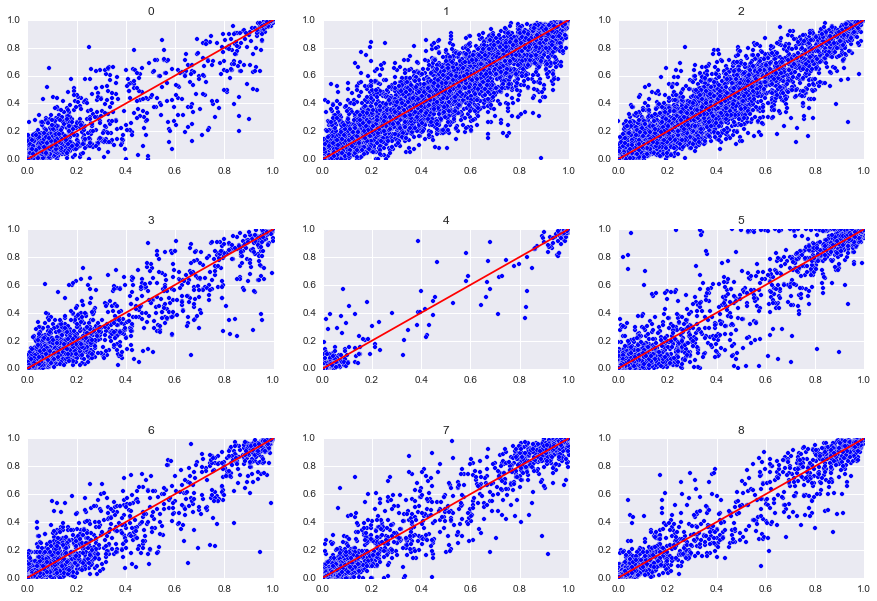

In [65]:
# check the difference of predicted values
fig = plt.figure(figsize = (15, 10) )
for index, column in enumerate(xgb_m1.columns.values):
    ax = fig.add_subplot(3, 3, index + 1)
    ax.scatter(xgb_m1[column], xgb_m2[column])
    ax.plot( [0,1], [0,1], color = 'r' )
    ax.set_title(column)
    ax.set_xlim( (0, 1) )
    ax.set_ylim( (0, 1) )

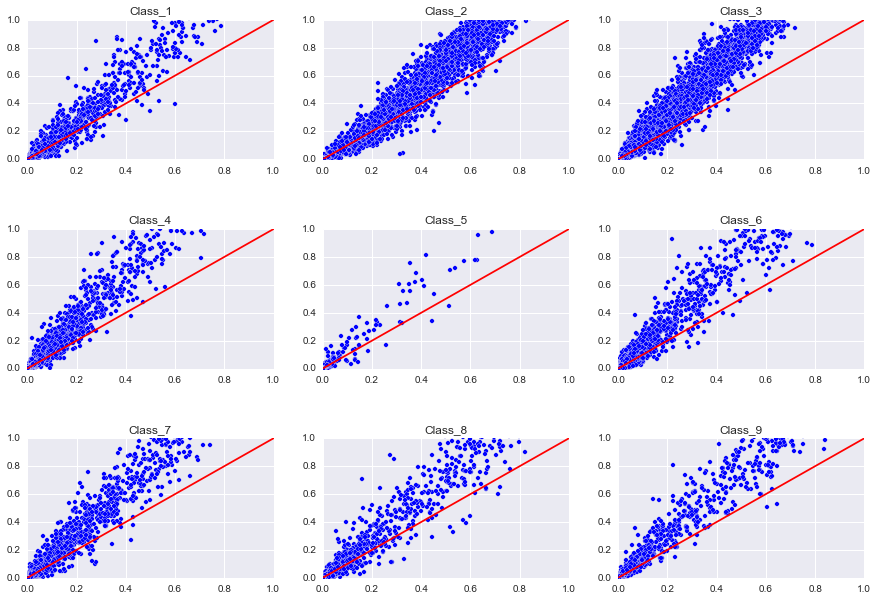

In [22]:
# check the difference of predicted values
fig = plt.figure(figsize = (15, 10) )
for index, column in enumerate(predicted_h2o_1.columns.values):
    ax = fig.add_subplot(3, 3, index + 1)
    ax.scatter(predicted_h2o_1[column], predicted_h2o_2[column])
    ax.plot( [0,1], [0,1], color = 'r' )
    ax.set_title(column)
    ax.set_xlim( (0, 1) )
    ax.set_ylim( (0, 1) )

In [141]:
predicted_m8  = pd.read_csv("xgboost_blend/predicted_m8_fold0.csv")
predicted_m14 = pd.read_csv("xgboost_blend/predicted_m14_fold0.csv")
predicted_m20 = pd.read_csv("xgboost_blend/predicted_m20_fold0.csv")

In [319]:
predicted_xgb = ( predicted_m14 + predicted_m20 ) / 2.0

In [144]:
predicted_m8[:2]

,0,1,2,3,4,5,6,7,8
0,0.019635,0.000001,0.000008,0.000095,0.000000,0.978280,0.000283,0.001249,0.000449
1,0.006670,0.001174,0.000720,0.000165,0.000169,0.001144,0.002047,0.987702,0.000210


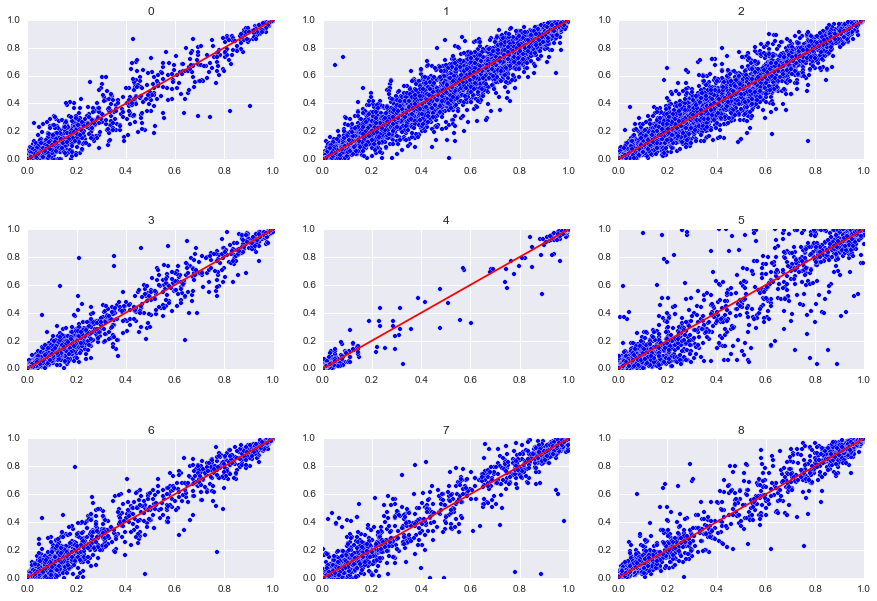

In [320]:
# check the difference of predicted values
fig = plt.figure(figsize = (15, 10) )
for index, column in enumerate(xgb_m1.columns.values):
    ax = fig.add_subplot(3, 3, index + 1)
    ax.scatter(xgb_m1[column], predicted_xgb[column])
    ax.plot( [0,1], [0,1], color = 'r' )
    ax.set_title(column)
    ax.set_xlim( (0, 1) )
    ax.set_ylim( (0, 1) )

In [321]:
log_loss(y_test_cv, predicted_xgb.values)

0.45263785003040857

In [331]:
# blend the blend of xgboost with m14
w14 = 2.0
wb  = 0.5
m14_blend = (w14 * predicted_xgb + wb * predicted_xgblend) / (w14 + wb)

log_loss(y_test_cv, m14_blend.values)

0.45240885523826324

In [ ]:
# score on LB
weights = [1.7, 1.8, 0.9, 1.1, 2.3, 0.4, 3.0, 2.0]

#Output CV dataset for H2O

In [ ]:
for index, (train_index, test_index) in enumerate(kf):
    train_cv, test_cv = train.values[train_index], train.values[test_index]
    pd.DataFrame(train_cv).to_csv("train_cv" + str(index) + ".csv", index=False)
    pd.DataFrame(test_cv).to_csv("test_cv" + str(index) + ".csv", index=False)
    print np.shape(test_cv)

#Predict on LB

In [150]:
dtrain = xgb.DMatrix( np.sqrt(3.0/8 + X_train.values), label = y_train.values)

In [152]:
X_test = test.drop(['id'], axis=1)
dtest  = xgb.DMatrix( np.sqrt(3.0/8 + X_test.values) )

In [151]:
params_m14 = {'max_depth': 14, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss',
              'learning_rate': 0.02, 'min_child_weight': 6,
              'colsample_bytree': 0.5, 'subsample': 0.8,  
              'seed': 26, 'nthread': 16, 'num_class': 9 }

xgb_m14 = xgb.train(params_m14, dtrain = dtrain, num_boost_round = 1369)

In [153]:
predicted_m14 = xgb_m14.predict(dtest)

In [154]:
params_m20 = {'max_depth': 22, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss',
              'learning_rate': 0.02, 'min_child_weight': 9,
              'colsample_bytree': 0.5578, 'subsample': 0.9021,          
              'seed': 26, 'nthread': 16, 'num_class': 9 }

xgb_m20 = xgb.train(params_m20, dtrain = dtrain, num_boost_round = 1113)

In [155]:
predicted_m20 = xgb_m20.predict(dtest)

In [159]:
# check
np.corrcoef(predicted_m14[:,0], predicted_m20[:,0])

array([[ 1.        ,  0.99541944],
       [ 0.99541944,  1.        ]])

In [160]:
predicted_xgb = (predicted_m14 + predicted_m20) / 2.0

In [161]:
pd.DataFrame(predicted_xgb).to_csv("test_predicted_xgboost.csv", index=False)

#Blending xgboost

In [13]:
# use the same kf
kf = StratifiedKFold(y_train.values, n_folds=5, shuffle=False, random_state=26)

In [77]:
def run_blending( X_train, y_train, kf, weights = [1.0, 1.0, 1.0] ):
    
    folds = 5
    
    X = X_train
    y = y_train
    
    train_cv_error = np.empty( folds ) 
    test_cv_error  = np.empty( folds )
        
    params_m8 = {'max_depth': 8, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss',
                 'learning_rate': 0.05, 'min_child_weight': 5,
                 'colsample_bytree': 0.4426, 'subsample': 0.7809,         
                 'seed': 26, 'nthread': 16, 'num_class': 9 }
      
    params_m20 = {'max_depth': 22, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss',
                  'learning_rate': 0.02, 'min_child_weight': 9,
                  'colsample_bytree': 0.5578, 'subsample': 0.9021,          
                  'seed': 26, 'nthread': 16, 'num_class': 9 }
    
    params_m14 = {'max_depth': 14, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss',
                  'learning_rate': 0.02, 'min_child_weight': 6,
                  'colsample_bytree': 0.5, 'subsample': 0.8,  
                  'seed': 26, 'nthread': 16, 'num_class': 9 }
    
    for index, (train_index, test_index) in enumerate(kf):
        print "fold ", index
        if index == 0:
            continue
            
        if index == 1:
            continue
            
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
    
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dtest  = xgb.DMatrix(X_test_cv)
        
        s = time()
        print "start training"
        xgb_m8  = xgb.train(params_m8, dtrain = dtrain, num_boost_round = 2549)   # CV: 0.451267+0.006602 
        xgb_m14 = xgb.train(params_m14, dtrain = dtrain, num_boost_round = 1369)  # CV: 0.447299
        xgb_m20 = xgb.train(params_m20, dtrain = dtrain, num_boost_round = 1113)  # CV: 0.448022
        print "elapsed: {}s ".format( int( round( time() - s )))
        
        w8  = weights[0]
        w14 = weights[1]
        w20 = weights[2]
        
        predicted_m8  = xgb_m8.predict(dtest) 
        print "log loss m8: ", log_loss( y_test_cv, predicted_m8 ) 
        predicted_m14 = xgb_m14.predict(dtest)
        print "log loss m8: ", log_loss( y_test_cv, predicted_m14 ) 
        predicted_m20 = xgb_m20.predict(dtest)
        print "log loss m8: ", log_loss( y_test_cv, predicted_m20 ) 

        # write prediction to files
        print "write predictions to file"
        pd.DataFrame(predicted_m8 ).to_csv("predicted_m8_fold" + str(index) + ".csv", index=False)
        pd.DataFrame(predicted_m14).to_csv("predicted_m14_fold" + str(index) + ".csv", index=False)
        pd.DataFrame(predicted_m20).to_csv("predicted_m20_fold" + str(index) + ".csv", index=False)
       
        predicted = (w20*predicted_m20 + w8*predicted_m8 + w14*predicted_m14) / (w8 + w14 + w20)
             
        test_cv_error[index]  = log_loss( y_test_cv, predicted ) 
        print "test_error ", str(test_cv_error[index])

    test_error  = np.mean(test_cv_error)
    return test_error

In [78]:
run_blending( np.sqrt(3.0/8 + X_train.values), y_train.values, kf, weights = [1.0, 1.0, 1.0] )

fold  0
fold  1
fold  2
start training
elapsed: 784s 
log loss m8:  0.477938893808
log loss m8:  0.444056487847
log loss m8:  0.443849874402
write predictions to file
test_error  0.444525824587
fold  3
start training
elapsed: 788s 
log loss m8:  0.470790942903
log loss m8:  0.437959650757
log loss m8:  0.437902740265
write predictions to file
test_error  0.438239435167
fold  4
start training
elapsed: 797s 
log loss m8:  0.477999606891
log loss m8:  0.44369951058
log loss m8:  0.445102130063
write predictions to file
test_error  0.444631445508


0.26547934105220838

In [4]:
predicted_m8  = pd.read_csv("predicted_m8_fold0.csv")
predicted_m14 = pd.read_csv("predicted_m14_fold0.csv")
predicted_m20 = pd.read_csv("predicted_m20_fold0.csv")

In [38]:
for index, (train_index, test_index) in enumerate(kf):
    if index == 0:
        X_train_cv, X_test_cv = X_train.values[train_index], X_train.values[test_index]
        y_train_cv, y_test_cv = y_train.values[train_index], y_train.values[test_index]

In [75]:
w8  = 1.0
w14 = 10.0
w20 = 10.0

predicted = (w8*predicted_m8 + w14*predicted_m14 + w20*predicted_m20) / (w8 + w14 + w20)

In [76]:
log_loss( y_test_cv, predicted.values )

0.44938794802316961

# xgboost calibration

In [ ]:
# try calibrated probability
def run_calibrated_xgboost( X_train, y_train ):
    
    folds = 5
    kf = StratifiedKFold(y_train, n_folds=folds, shuffle=False)
    X = X_train
    y = y_train
    
    train_cv_error = np.empty( folds ) 
    test_cv_error  = np.empty( folds )

    params_m14 = {'max_depth': 14, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss',
                  'learning_rate': 0.02, 'min_child_weight': 6,
                  'colsample_bytree': 0.5, 'subsample': 0.8,  
                  'seed': 26, 'nthread': 16, 'num_class': 9 }

    for index, (train_index, test_index) in enumerate(kf):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dtest  = xgb.DMatrix(X_test_cv)
        
        xgb_fit = xgb.train(params_m14, dtrain, num_boost_round = 1369)
        cal_xgb_fit = CalibratedClassifierCV(xgb_fit, method="isotonic", cv = 5)
        cal_xgb_fit.fit(X_train_cv, y_train_cv)  
        
        train_cv_error[index] = log_loss( y_train, ccal_xgb_fit.predict(dtest) ) 
        test_cv_error[index]  = log_loss( y_test, cal_xgb_fit.predict(dtrain) ) 

    train_error = np.mean(train_cv_error)
    test_error  = np.mean(test_cv_error)
    return train_error, test_error

# Visualize predictions

In [ ]:
columns = pd.Series(np.arange(1, 10)).apply(lambda x: "Class_" + str(x))

In [ ]:
predicted_m8  = pd.read_csv("predicted_m8_fold0.csv", names = columns)
predicted_m14 = pd.read_csv("predicted_m14_fold0.csv", names = columns)
predicted_m20 = pd.read_csv("predicted_m20_fold0.csv", names = columns)

predicted_rf36 = pd.read_csv("predicted_RF_depth36_fold0.csv", names = columns)

In [ ]:
# check the difference of predicted values
fig = plt.figure(figsize = (15, 10) )
for index, column in enumerate(columns):
    ax = fig.add_subplot(3, 3, index + 1)
    ax.scatter(predicted_m8[column], predicted_m14[column])
    ax.plot( [0,1], [0,1], color = 'r' )
    ax.set_title(column)
    ax.set_xlim( (0, 1) )
    ax.set_ylim( (0, 1) )

# Training with subset of features

In [11]:
set1 = np.arange(1, 12)
set2 = np.arange(12, 24)
set3 = np.arange(24, 35)
set4 = np.arange(35, 47)
set5 = np.arange(47, 58)
set6 = np.arange(58, 70)
set7 = np.arange(70, 82)
set8 = np.arange(82, 94)

In [12]:
feature_set = [set1, set2, set3, set4, set5, set6, set7, set8]

In [13]:
# add the prefix "feat_"
for i, features in enumerate(feature_set):
    features = pd.Series(features).apply(lambda x: "feat_" + str(x)).values
    feature_set[i] = features

In [22]:
# train to find the best ntree for model
params = {'max_depth': 14,
             'objective': 'multi:softprob',
             'eval_metric': 'mlogloss',
             'learning_rate': 0.05, 
             'min_child_weight': 6,
             'colsample_bytree': 0.5,   # column subsample
             'subsample': 0.8,           # row subsample
             'num_class': 9,
             'seed': 26,
             'nthread': 16,
             'silent': False
            }

In [20]:
xgb_fit1 = xgb.cv(params, xgb.DMatrix(X_train.drop(feature_set[0], axis = 1).values, label=y_train.values), 
                  num_boost_round=2500, nfold=5)
# with learning_rate = 0.02
# [1090] cv-test-mlogloss:0.484028+0.006998     cv-train-mlogloss:0.141579+0.000518

# with learning_rate = 0.05
# [421]	cv-test-mlogloss:0.483885+0.007270	cv-train-mlogloss:0.143548+0.000887

# [481]	cv-test-mlogloss:0.470990+0.007332	cv-train-mlogloss:0.136214+0.000429


[0]	cv-test-mlogloss:2.089236+0.003462	cv-train-mlogloss:2.084473+0.002887
[1]	cv-test-mlogloss:1.997554+0.004020	cv-train-mlogloss:1.987815+0.003596
[2]	cv-test-mlogloss:1.914128+0.003974	cv-train-mlogloss:1.899849+0.003246
[3]	cv-test-mlogloss:1.838477+0.004768	cv-train-mlogloss:1.819938+0.004255
[4]	cv-test-mlogloss:1.772167+0.004356	cv-train-mlogloss:1.749798+0.003859
[5]	cv-test-mlogloss:1.711870+0.003639	cv-train-mlogloss:1.685641+0.003595
[6]	cv-test-mlogloss:1.656409+0.004157	cv-train-mlogloss:1.626480+0.004156
[7]	cv-test-mlogloss:1.604391+0.003111	cv-train-mlogloss:1.570789+0.003747
[8]	cv-test-mlogloss:1.557076+0.002509	cv-train-mlogloss:1.519996+0.003273
[9]	cv-test-mlogloss:1.511920+0.002425	cv-train-mlogloss:1.471516+0.003620
[10]	cv-test-mlogloss:1.470130+0.002127	cv-train-mlogloss:1.426444+0.003495
[11]	cv-test-mlogloss:1.430190+0.001922	cv-train-mlogloss:1.383489+0.003306
[12]	cv-test-mlogloss:1.393206+0.001673	cv-train-mlogloss:1.343404+0.003490
[13]	cv-test-mlogloss:

KeyboardInterrupt: 

In [24]:
xgb_fit8 = xgb.cv(params, xgb.DMatrix(X_train.drop(feature_set[7], axis = 1).values, label=y_train.values), 
                  num_boost_round=2000, nfold=5)

# [1005]	cv-test-mlogloss:0.487040+0.006388	cv-train-mlogloss:0.166505+0.000901

[0]	cv-test-mlogloss:2.087413+0.006525	cv-train-mlogloss:2.083264+0.005978
[1]	cv-test-mlogloss:1.994109+0.005889	cv-train-mlogloss:1.985699+0.005674
[2]	cv-test-mlogloss:1.912622+0.006600	cv-train-mlogloss:1.900438+0.006108
[3]	cv-test-mlogloss:1.839739+0.006668	cv-train-mlogloss:1.823162+0.006423
[4]	cv-test-mlogloss:1.772459+0.006167	cv-train-mlogloss:1.752086+0.005838
[5]	cv-test-mlogloss:1.712413+0.005916	cv-train-mlogloss:1.688247+0.005540
[6]	cv-test-mlogloss:1.657556+0.007592	cv-train-mlogloss:1.629860+0.007134
[7]	cv-test-mlogloss:1.605498+0.007462	cv-train-mlogloss:1.574299+0.007350
[8]	cv-test-mlogloss:1.556368+0.008138	cv-train-mlogloss:1.521612+0.007363
[9]	cv-test-mlogloss:1.512019+0.008631	cv-train-mlogloss:1.473814+0.006941
[10]	cv-test-mlogloss:1.470595+0.010278	cv-train-mlogloss:1.429314+0.008643
[11]	cv-test-mlogloss:1.432430+0.009268	cv-train-mlogloss:1.388204+0.007377
[12]	cv-test-mlogloss:1.395680+0.008400	cv-train-mlogloss:1.348631+0.006197
[13]	cv-test-mlogloss:

KeyboardInterrupt: 

In [30]:
# blend the model together 
def blend_subset_model():
    
    ntree = 420
    N = y_train.values.shape[0]
    folds = 5
    kf = StratifiedKFold(y_train.values, n_folds=folds, shuffle=False)
    
    X1 = X_train.drop(feature_set[0], axis=1).values
    X2 = X_train.drop(feature_set[1], axis=1).values
    X3 = X_train.drop(feature_set[2], axis=1).values
    X4 = X_train.drop(feature_set[3], axis=1).values
    X5 = X_train.drop(feature_set[4], axis=1).values
    X6 = X_train.drop(feature_set[5], axis=1).values
    X7 = X_train.drop(feature_set[6], axis=1).values
    X8 = X_train.drop(feature_set[7], axis=1).values

    y = y_train.values
    
    train_cv_error = np.empty( folds ) 
    test_cv_error  = np.empty( folds )
    
    params = {'max_depth': 14,
             'objective': 'multi:softprob',
             'eval_metric': 'mlogloss',
             'learning_rate': 0.05, 
             'min_child_weight': 6,
             'colsample_bytree': 0.5,    # column subsample
             'subsample': 0.8,           # row subsample
             'num_class': 9,
             'seed': 26,
             'nthread': 16,
             'silent': False
            }
    
    for index, (train_index, test_index) in enumerate(kf):
        X1_train_cv, X1_test_cv = X1[train_index], X1[test_index]
        X2_train_cv, X2_test_cv = X2[train_index], X2[test_index]
        X3_train_cv, X3_test_cv = X3[train_index], X3[test_index]
        X4_train_cv, X4_test_cv = X4[train_index], X4[test_index]
        X5_train_cv, X5_test_cv = X5[train_index], X5[test_index]
        X6_train_cv, X6_test_cv = X6[train_index], X6[test_index]
        X7_train_cv, X7_test_cv = X7[train_index], X7[test_index]
        X8_train_cv, X8_test_cv = X8[train_index], X8[test_index]

        y_train_cv, y_test_cv = y[train_index], y[test_index]
        
        # prepare data
        dtrain1 = xgb.DMatrix(X1_train_cv, label=y_train_cv)
        dtrain2 = xgb.DMatrix(X2_train_cv, label=y_train_cv)
        dtrain3 = xgb.DMatrix(X3_train_cv, label=y_train_cv)
        dtrain4 = xgb.DMatrix(X4_train_cv, label=y_train_cv)
        dtrain5 = xgb.DMatrix(X5_train_cv, label=y_train_cv)
        dtrain6 = xgb.DMatrix(X6_train_cv, label=y_train_cv)
        dtrain7 = xgb.DMatrix(X7_train_cv, label=y_train_cv)
        dtrain8 = xgb.DMatrix(X8_train_cv, label=y_train_cv)

        dtest1  = xgb.DMatrix(X1_test_cv)
        dtest2  = xgb.DMatrix(X2_test_cv)
        dtest3  = xgb.DMatrix(X3_test_cv)
        dtest4  = xgb.DMatrix(X4_test_cv)
        dtest5  = xgb.DMatrix(X5_test_cv)
        dtest6  = xgb.DMatrix(X6_test_cv)
        dtest7  = xgb.DMatrix(X7_test_cv)
        dtest8  = xgb.DMatrix(X8_test_cv)

        # training
        xgb_fit1 = xgb.train(params, dtrain = dtrain1, num_boost_round = 481)   # 0.470990+0.007332
        xgb_fit2 = xgb.train(params, dtrain = dtrain2, num_boost_round = 475)   # 0.474821+0.005874
        xgb_fit3 = xgb.train(params, dtrain = dtrain3, num_boost_round = 507)   # 0.502230+0.008370
        xgb_fit4 = xgb.train(params, dtrain = dtrain4, num_boost_round = 486)   # 0.493332+0.005040
        xgb_fit5 = xgb.train(params, dtrain = dtrain5, num_boost_round = 449)   # 0.476854+0.005784
        xgb_fit6 = xgb.train(params, dtrain = dtrain6, num_boost_round = 482)   # 0.497765+0.008884
        xgb_fit7 = xgb.train(params, dtrain = dtrain7, num_boost_round = 480)   # 0.471025+0.006974
        xgb_fit8 = xgb.train(params, dtrain = dtrain8, num_boost_round = 480)   # 0.480579+0.006058
       
        # predict on validation set
        w1 = 5
        w2 = 3
        w3 = 1
        w4 = 1
        w5 = 3
        w6 = 1
        w7 = 5
        w8 = 2
        predicted = ( w1*xgb_fit1.predict(dtest1) + w2*xgb_fit2.predict(dtest2) + w3*xgb_fit3.predict(dtest3) 
                    + w4*xgb_fit4.predict(dtest4) + w5*xgb_fit5.predict(dtest5) + w6*xgb_fit6.predict(dtest6)
                    + w7*xgb_fit7.predict(dtest7) + w8*xgb_fit8.predict(dtest8)) / (w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8)
        test_cv_error[index]  = log_loss( y_test_cv, predicted ) 

    test_error  = np.mean(test_cv_error)
    test_std    = np.std(test_cv_error)
    return test_error, test_std

In [31]:
blend_subset_model()

(0.45593851717259631, 0.0056945176498096077)

# CV with Accuracy report

In [127]:
# X and y are numpy array
def run_cv2( X, y, params, ntree ):
    
    N = y.shape[0]
    folds = 5
    kf = StratifiedKFold(y, n_folds=folds, shuffle=False)
    
    train_cv_error = np.empty( folds ) 
    test_cv_error  = np.empty( folds )
    acc            = np.empty( folds )
    classe_acc     = np.empty( (folds, 9) )
        
    for index, (train_index, test_index) in enumerate(kf):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
    
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dtest  = xgb.DMatrix(X_test_cv)
        
        xgb_fit = xgb.train(params, dtrain = dtrain, num_boost_round = ntree)  # 198 rounds
        predicted = xgb_fit.predict(dtest)
        test_cv_error[index]  = log_loss( y_test_cv, predicted ) 
        acc[index], classe_acc[index] = accuracy_report(predicted, y_test_cv)

    # train_error = np.mean(train_cv_error)
    test_error  = np.mean(test_cv_error)
    return test_error, np.mean(acc), np.mean(classe_acc, axis = 0)  # take mean over columns / folds

In [129]:
run_cv2( X_train.values, y_train.values, params_m14, 1190)

(0.45479844050690482,
 0.82620636240668122,
 array([ 0.54379651,  0.8590749 ,  0.55859713,  0.52693822,  0.97152351,
         0.94785992,  0.69249696,  0.93348254,  0.89001009]))

In [125]:
y_train[:5]

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [126]:
accuracy_report(predicted, y_train.values)

(0.97587187691909882,
 array([ 0.96474857,  0.98585783,  0.92628686,  0.89892233,  0.99634903,
         0.99554298,  0.95984502,  0.99007561,  0.98708375]))

# Tuning subsample

In [28]:
col_subsamples = [0.28613933495037946, 0.745471484885613, 0.05753069516808973, 0.12814407203400036, 0.039962974149974184,
                 0.2631448495974139, 0.2682597758139009, 0.31154436112759, 0.9481091658402698, 0.38114454181934154,
                 0.12966085928477078, 0.44776424484714517, 0.32769470030065484, 0.14816782846416143, 0.08854402816348483,
                 0.7052301115139145, 0.753244840801039, 0.10873231990090226, 0.5223948976356186, 0.5578075357861046, 
                 0.6302021205011633, 0.6020396357722513, 0.8956623587096002, 0.6305241648071939, 0.5206691510731246, 
                 0.8593597683591111, 0.6178168660383081, 0.8209070100748117, 0.458914732438049, 0.5610556839487759]
subsample = [0.6964691855978616, 0.10606490595473272, 0.50672601149957, 0.10517212721767522, 0.5238333199546759, 
            0.8666370428503979, 0.5705316251454068, 0.1416302690767407, 0.650153605471749, 0.7809038987924661,
            0.4195086163487056, 0.8114036263085849, 0.6613289424499647, 0.15321593689979662, 0.9438502081196458,
            0.7493422613186888, 0.4909623875237653, 0.7479055164963537, 0.9173854839516489, 0.9020615248125082,
            0.981746757032038, 0.3126587454558365, 0.980952422976614, 0.8730708106461605, 0.9925314929899058, 
            0.2953775533298131, 0.9984715183930019, 0.8425897232209364, 0.6072429238600898, 0.9328882543499166 ]
score = [0.503727925618, 0.542521308705, 0.848214877875, 0.683636007388, 1.02307117242, 
        0.503845403049, 0.514700072756, 0.558236681716, 0.477989308236, 0.484419176663, 
        0.613259397286, 0.477282332603, 0.494677760555, 0.636516350725, 0.685745671099, 
        0.472533566147, 0.481699777196, 0.638406660563, 0.472599927831, 0.471218967334, 
        0.469590267252, 0.497392380683, 0.474061533456, 0.471707135974, 0.472097882645, 
        0.496690980995, 0.472256224221, 0.471898867627, 0.484320505332, 0.472028192091]

In [39]:
X, Y = np.meshgrid(col_subsamples, subsample)

In [30]:
# To use 3D graphics in matplotlib, we first need to create an instance of the Axes3D class. 
# 3D axes can be added to a matplotlib figure canvas in exactly the same way as 2D axes; or, more conveniently, 
# by passing a projection='3d' keyword argument to the add_axes or add_subplot methods.

from mpl_toolkits.mplot3d.axes3d import Axes3D

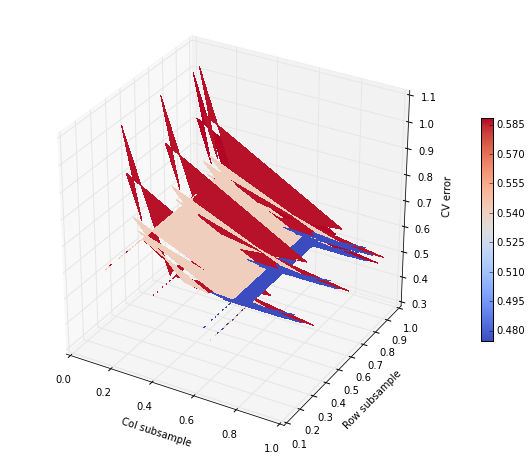

In [44]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d')
p = ax.plot_surface(X, Y, score, 
                    rstride=10, cstride=10, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(0.3, 1.1)
ax.set_xlabel('Col subsample')
ax.set_ylabel('Row subsample')
ax.set_zlabel('CV error')
cb = fig.colorbar(p, shrink=0.5)
plt.show()

In [58]:
ntree = 3000
early_stop = 5

In [ ]:
params_m20 = {'max_depth': 22,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.01, 
              'min_child_weight': 4,
              'colsample_bytree': 0.5578,   # column subsample
              'subsample': 0.9021,           # row subsample
              'num_class': 9,
              'silent': False
              }

xgb_m20 = xgb.cv(params_m20, xgb.DMatrix(X_train, label=y_train), num_boost_round = ntree, nfold=5)

In [86]:
def run_test2( args ):
    
    N = y_train.values.shape[0]
    folds = 5
    kf = StratifiedKFold(y_train.values, n_folds=folds, shuffle=True)
    
    X = X_train.values
    y = y_train.values
    
    train_cv_error = np.empty( folds ) 
    test_cv_error  = np.empty( folds )
    acc            = np.empty( folds )
    classe_acc     = np.empty( (folds, 9) )
        
    # print "params: ", str(args)
    params_m8 = {'max_depth': 8,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.05, 
              'min_child_weight': 5,
              'colsample_bytree': 0.4426,   # column subsample
              'subsample': 0.7809,          # row subsample
              'seed': 26,
              'num_class': 9
              }
    
    
    params_m20 = {'max_depth': 22,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.05, 
              'min_child_weight': 9,
              'colsample_bytree': 0.5578,   # column subsample
              'subsample': 0.9021,           # row subsample
              'num_class': 9,
              'seed': 26,
              'silent': False
              }
    
    params_m14 = {'max_depth': 14,
             'objective': 'multi:softprob',
             'eval_metric': 'mlogloss',
             'learning_rate': 0.05, 
             'min_child_weight': 6,
             'colsample_bytree': 0.5,   # column subsample
             'subsample': 0.8,           # row subsample
             'gamma': 0.0,
             'num_class': 9,
             'seed': 26,
             'silent': False
            }
    
    for index, (train_index, test_index) in enumerate(kf):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
    
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dtest  = xgb.DMatrix(X_test_cv)
        
        xgb_m20 = xgb.train(params_m20, dtrain = dtrain, num_boost_round = 400)   # CV: 0.457486+0.007155
        xgb_m8  = xgb.train(params_m8, dtrain = dtrain, num_boost_round = 880)    # CV: 0.459027+0.006627
        xgb_m14 = xgb.train(params_m14, dtrain = dtrain, num_boost_round = 500)   # CV: 0.456631+0.007237
        
        predicted = (2.0*xgb_m20.predict(dtest) + xgb_m8.predict(dtest) + 5.0*xgb_m14.predict(dtest)) / 8.0
        
        # predicted = xgb_fit.predict(dtest)
        # predicted = calibrate_proba2(predicted, 0.5, 9)
        
        test_cv_error[index]  = log_loss( y_test_cv, predicted ) 
        acc[index], classe_acc[index] = accuracy_report(predicted, y_test_cv)

    test_error  = np.mean(test_cv_error)
    return test_error, np.mean(acc), np.mean(classe_acc, axis = 0) 

In [87]:
run_test2( {} )

(0.45320521962331367,
 0.82722478337108796,
 array([ 0.54534554,  0.86205151,  0.55572174,  0.54403308,  0.9718878 ,
         0.94785992,  0.69250751,  0.93277541,  0.88879919]))

In [ ]:
params_m8 = {'max_depth': 8,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.01, 
              'min_child_weight': 5,
              'colsample_bytree': 0.4426,   # column subsample
              'subsample': 0.7809,          # row subsample
              'seed': 26,
              'num_class': 9
              }
    
    
params_m20 = {'max_depth': 22,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.005, 
              'min_child_weight': 9,
              'colsample_bytree': 0.5578,   # column subsample
              'subsample': 0.9021,           # row subsample
              'num_class': 9,
              'seed': 26,
              'silent': False
              }

dtrain = xgb.DMatrix(X_train, label=y_train)
xgb_m20 = xgb.train(params_m20, dtrain = dtrain, num_boost_round = 3812)
xgb_m8 = xgb.train(params_m8, dtrain = dtrain, num_boost_round = 4470)

In [ ]:
predicted = (2.0*xgb_m20.predict( xgb.DMatrix(test.drop(['id'], axis=1)) ) 
             + xgb_m8.predict( xgb.DMatrix(test.drop(['id'], axis=1)) ) ) / 3.0

In [44]:
space = (
    hp.choice( 'max_depth', [8, 10] ),
    hp.choice( 'min_child_weight', [2, 3, 4, 5, 6, 7, 8]),
    hp.uniform( 'colsample_bytree', 0, 1),
    hp.uniform( 'subsample', 0, 1),
    hp.uniform( 'gamma', 0, 1)
)

In [15]:
np.arange(6, 32, step = 2)

array([ 6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

In [43]:
learning_rate = 0.05
ntree = 1000

In [39]:
def run_test( args ):
    
    N = y_train.values.shape[0]
    folds = 5
    kf = StratifiedKFold(y_train.values, n_folds=folds, shuffle=True)
    
    X = X_train.values
    y = y_train.values
    
    train_cv_error = np.empty( folds ) 
    test_cv_error  = np.empty( folds )
    
    # print "params: ", str(args)
    params = {'max_depth': args[0],
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': learning_rate, 
              'min_child_weight': args[1],
              'colsample_bytree': args[2],   # column subsample
              'subsample': args[3],          # row subsample
              'gamma': args[4],
              'num_class': 9,
              'silent': True
              }
    
    for index, (train_index, test_index) in enumerate(kf):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
    
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dtest  = xgb.DMatrix(X_test_cv)
        # watchlist  = [(dtest,'eval'), (dtrain,'train')]

        xgb_fit = xgb.train(params, dtrain = dtrain, num_boost_round = ntree)
        # train_cv_error[index] = log_loss( y_train_cv, xgb_fit.predict(dtrain) ) 
        test_cv_error[index]  = log_loss( y_test_cv, xgb_fit.predict(dtest) ) 

    # train_error = np.mean(train_cv_error)
    test_error  = np.mean(test_cv_error)
    test_std    = np.std(test_cv_error)
    return test_error, test_std

In [40]:
def run_wrapper( args ):
    global run_counter
    
    run_counter += 1
    print "run " + str(run_counter)
    
    s = time()
    test_error, test_std = run_test( args )
    
    print "params     : ", str(args)
    print "test error : ", str(test_error) + "  | std: " + str( test_std  )    
    print "elapsed: {}s \n".format( int( round( time() - s )))
    
    return test_error

In [45]:
run_counter = 0

best = fmin( run_wrapper,           # function to minimize
             space,                 # search space
             algo = tpe.suggest,    # algo
             max_evals = 100         # max iterations
             )

run 1
params     :  (8, 8, 0.5513147690828912, 0.6964691855978616, 0.2268514535642031)
test error :  0.461332930674  | std: 0.0057403458291
elapsed: 504s 

run 2
params     :  (10, 3, 0.4582411837608814, 0.10606490595473272, 0.5723135366314989)
test error :  0.492725841271  | std: 0.00688651773096
elapsed: 260s 

run 3
params     :  (10, 4, 0.13255252720015986, 0.50672601149957, 0.6275799857910759)
test error :  0.479592766654  | std: 0.00757408284084
elapsed: 362s 

run 4
params     :  (10, 4, 0.11547856267104184, 0.10517212721767522, 0.08740630845952124)
test error :  0.522366305866  | std: 0.00428380874598
elapsed: 201s 

run 5
params     :  (8, 4, 0.7727906479529085, 0.5238333199546759, 0.18596531220043622)
test error :  0.4666226309  | std: 0.00504283608848
elapsed: 594s 

run 6
params     :  (8, 7, 0.041593443747687364, 0.8666370428503979, 0.131408478173487)
test error :  0.608267170207  | std: 0.00347361351481
elapsed: 153s 

run 7
params     :  (8, 2, 0.08485637761245057, 0.570

KeyboardInterrupt: 

In [15]:
params_m8 = {'max_depth': 8,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.05, 
              'min_child_weight': 5,
              'colsample_bytree': 0.4426,   # column subsample
              'subsample': 0.7809,          # row subsample
              'num_class': 9
              }

In [24]:
xgb_m8 = xgb.cv(params_m8, xgb.DMatrix(X_train, label=y_train), num_boost_round = 3500, nfold=5)

[0]	cv-test-mlogloss:2.176872+0.000946	cv-train-mlogloss:2.176300+0.001059
[1]	cv-test-mlogloss:2.157221+0.001227	cv-train-mlogloss:2.156107+0.001435
[2]	cv-test-mlogloss:2.138068+0.001296	cv-train-mlogloss:2.136498+0.001483
[3]	cv-test-mlogloss:2.119209+0.002086	cv-train-mlogloss:2.117218+0.002127
[4]	cv-test-mlogloss:2.101703+0.002216	cv-train-mlogloss:2.099203+0.002173
[5]	cv-test-mlogloss:2.083729+0.001737	cv-train-mlogloss:2.080698+0.001689
[6]	cv-test-mlogloss:2.066158+0.001614	cv-train-mlogloss:2.062641+0.001741
[7]	cv-test-mlogloss:2.050583+0.001282	cv-train-mlogloss:2.046666+0.001457
[8]	cv-test-mlogloss:2.033762+0.001138	cv-train-mlogloss:2.029422+0.000863
[9]	cv-test-mlogloss:2.017342+0.000670	cv-train-mlogloss:2.012527+0.000689
[10]	cv-test-mlogloss:2.001716+0.000809	cv-train-mlogloss:1.996417+0.000741
[11]	cv-test-mlogloss:1.986768+0.000730	cv-train-mlogloss:1.980940+0.000830
[12]	cv-test-mlogloss:1.971216+0.001580	cv-train-mlogloss:1.964971+0.001434
[13]	cv-test-mlogloss:

KeyboardInterrupt: 

In [35]:
params_m8 = {'max_depth': 8,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.01, 
              'min_child_weight': 5,
              'colsample_bytree': 0.4426,   # column subsample
              'subsample': 0.7809,          # row subsample
              'num_class': 9,
              }

xgb_m8 = xgb.cv(params_m8, xgb.DMatrix(X_train, label=y_train), num_boost_round = 8000, nfold=5)

[0]	cv-test-mlogloss:2.176913+0.000923	cv-train-mlogloss:2.176380+0.001057
[1]	cv-test-mlogloss:2.157289+0.001183	cv-train-mlogloss:2.156261+0.001423
[2]	cv-test-mlogloss:2.138378+0.000484	cv-train-mlogloss:2.136864+0.000778
[3]	cv-test-mlogloss:2.120228+0.000983	cv-train-mlogloss:2.118239+0.001259
[4]	cv-test-mlogloss:2.102675+0.001269	cv-train-mlogloss:2.100149+0.001599
[5]	cv-test-mlogloss:2.085269+0.001456	cv-train-mlogloss:2.082318+0.001749
[6]	cv-test-mlogloss:2.067771+0.001309	cv-train-mlogloss:2.064385+0.001578
[7]	cv-test-mlogloss:2.049924+0.001371	cv-train-mlogloss:2.046149+0.001538
[8]	cv-test-mlogloss:2.034077+0.001906	cv-train-mlogloss:2.029851+0.001563
[9]	cv-test-mlogloss:2.018681+0.001511	cv-train-mlogloss:2.014023+0.001105
[10]	cv-test-mlogloss:2.003314+0.001367	cv-train-mlogloss:1.998244+0.000846
[11]	cv-test-mlogloss:1.988377+0.002008	cv-train-mlogloss:1.982870+0.001454
[12]	cv-test-mlogloss:1.973329+0.002445	cv-train-mlogloss:1.967316+0.001917
[13]	cv-test-mlogloss:

KeyboardInterrupt: 

In [20]:
submit[:5]

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.000192,0.134090,0.167323,0.690567,0.000068,0.000120,0.007307,0.000298,0.000034
1,2,0.000426,0.002915,0.000718,0.000125,0.000079,0.276851,0.000722,0.717781,0.000383
2,3,0.000005,0.000007,0.000008,0.000003,0.000000,0.999739,0.000010,0.000213,0.000014
3,4,0.000156,0.618784,0.376054,0.003701,0.000011,0.000042,0.000112,0.000117,0.001023
4,5,0.145851,0.000232,0.000336,0.000047,0.000052,0.005089,0.001169,0.033565,0.813659


In [25]:
# save the model
xgb_m8.save_model("m8.model")
# dump model
# xgb_m8.dump_model('m8.dump.raw.txt')
# dump model with feature map
# xgb_m8.dump_model('m8.dump.raw.txt','m8.featmap.txt')

In [14]:
params_m20 = {'max_depth': 22,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.05, 
              'min_child_weight': 9,
              'colsample_bytree': 0.5578,   # column subsample
              'subsample': 0.9021,           # row subsample
              'num_class': 9,
              'seed': 260,
              'silent': False
              }

In [ ]:
# train another best model
xgb_m20 = xgb.cv(params_m20, xgb.DMatrix(X_train, label=y_train), num_boost_round = 8000, nfold=5)

In [15]:
xgb_m20 = xgb.train(params_m20, xgb.DMatrix(X_train, label=y_train), num_boost_round = 400)

In [21]:
def run_cv1( X, y, seed = 26 ):
    
    N = y.shape[0]
    folds = 5
    kf = StratifiedKFold(y, n_folds=folds, shuffle=True)
    
    params_m20 = {'max_depth': 22,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.05, 
              'min_child_weight': 9,
              'colsample_bytree': 0.5578,   # column subsample
              'subsample': 0.9021,           # row subsample
              'num_class': 9,
              'seed': seed,
              'silent': False
              }
    params_m8 = {'max_depth': 8,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.01, 
              'min_child_weight': 5,
              'colsample_bytree': 0.4426,   # column subsample
              'subsample': 0.7809,          # row subsample
              'num_class': 9,
              }
    
    
    train_cv_error = np.empty( folds ) 
    test_cv_error  = np.empty( folds )
    acc            = np.empty( folds )
    classe_acc     = np.empty( (folds, 9) )
        
    for index, (train_index, test_index) in enumerate(kf):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
    
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dtest  = xgb.DMatrix(X_test_cv)
        
        xgb_fit = xgb.train(params_m20, dtrain = dtrain, num_boost_round = 400)  # 198 rounds
        predicted = xgb_fit.predict(dtest)
        test_cv_error[index]  = log_loss( y_test_cv, predicted ) 
        acc[index], classe_acc[index] = accuracy_report(predicted, y_test_cv)

    # train_error = np.mean(train_cv_error)
    test_error  = np.mean(test_cv_error)
    return test_error, np.mean(acc), np.mean(classe_acc, axis = 0)  # take mean over columns / folds

In [22]:
run_cv1(X_train.values, y_train.values, seed = 260)   # seed = 260

(0.45614332259205465,
 0.82646501891554336,
 array([ 0.54484624,  0.854918  ,  0.56222127,  0.54031285,  0.97298403,
         0.94821365,  0.69391224,  0.93407411,  0.88960646]))

In [23]:
run_cv1(X_train.values, y_train.values, seed = 261)

(0.45640329579578698,
 0.82693314152340691,
 array([ 0.538093  ,  0.85901204,  0.56484057,  0.53771475,  0.97079158,
         0.9482844 ,  0.68897024,  0.93206514,  0.88920283]))

In [24]:
run_cv1(X_train.values, y_train.values, seed = 262)

(0.45691431771296181,
 0.82572172148980605,
 array([ 0.5350111 ,  0.85808292,  0.56184221,  0.53215096,  0.97371395,
         0.94750619,  0.69284534,  0.93277457,  0.88335015]))

In [25]:
run_cv1(X_train.values, y_train.values, seed = 263)

(0.45668538122232077,
 0.82572144473468434,
 array([ 0.54433618,  0.85448466,  0.55871822,  0.53772579,  0.97371062,
         0.94814291,  0.69849032,  0.93242052,  0.88900101]))

In [47]:
xgb_m20.save_model("m20.model")

In [12]:
def run_test( args ):
    
    params_m20 = {'max_depth': 22,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.05, 
              'min_child_weight': 9,
              'colsample_bytree': 0.5578,   # column subsample
              'subsample': 0.9021,           # row subsample
              'num_class': 9,
              'seed': 260,
              'silent': False
              }
    
    
    N = y_train.values.shape[0]
    folds = 5
    kf = StratifiedKFold(y_train.values, n_folds=folds, shuffle=True)
    
    X = X_train.values
    y = y_train.values
    
    train_cv_error = np.empty( folds ) 
    test_cv_error  = np.empty( folds )
    
    # print "params: ", str(args)
    
    for index, (train_index, test_index) in enumerate(kf):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
    
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dtest  = xgb.DMatrix(X_test_cv)
        # watchlist  = [(dtest,'eval'), (dtrain,'train')]
        
        # xgb_fit = xgb.train(params_m20, dtrain = dtrain, num_boost_round = 400)
        xgb_m20 = xgb.train(params_m20, dtrain = dtrain, num_boost_round = 400)
        xgb_m8 = xgb.train(params_m8, dtrain = dtrain, num_boost_round = 880)
        predicted = (3.0*xgb_m20.predict(dtest) + xgb_m8.predict(dtest)) / 4.0
        
        # predicted = xgb_fit.predict(dtest)
        # predicted = calibrate_proba2(predicted, 0.5, 9)
        
        # train_cv_error[index] = log_loss( y_train_cv, xgb_fit.predict(dtrain) ) 
        test_cv_error[index]  = log_loss( y_test_cv, predicted ) 

    # train_error = np.mean(train_cv_error)
    test_error  = np.mean(test_cv_error)
    test_std    = np.std(test_cv_error)
    return test_error, test_std

In [31]:
def run_blend( args ):
    
    N = y_train.values.shape[0]
    folds = 5
    kf = StratifiedKFold(y_train.values, n_folds=folds, shuffle=True)
    
    X = X_train.values
    y = y_train.values
    
    params_m8 = {'max_depth': 8,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.05, 
              'min_child_weight': 5,
              'colsample_bytree': 0.4426,   # column subsample
              'subsample': 0.7809,          # row subsample
              'num_class': 9
              }
    
    train_cv_error = np.empty( folds ) 
    test_cv_error  = np.empty( folds )
    
    # print "params: ", str(args)
    
    for index, (train_index, test_index) in enumerate(kf):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
    
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dtest  = xgb.DMatrix(X_test_cv)
        # watchlist  = [(dtest,'eval'), (dtrain,'train')]
        
        # xgb_fit = xgb.train(params_m20, dtrain = dtrain, num_boost_round = 400)
        params_m8['seed'] = 260
        xgb_m8a = xgb.train(params_m8, dtrain = dtrain, num_boost_round = 880)
        params_m8['seed'] = 261
        xgb_m8b = xgb.train(params_m8, dtrain = dtrain, num_boost_round = 880)
        # params_m8['seed'] = 262
        # xgb_m8c = xgb.train(params_m8, dtrain = dtrain, num_boost_round = 880)
        predicted = (xgb_m8a.predict(dtest) + xgb_m8b.predict(dtest)) / 2.0
        
        # predicted = xgb_fit.predict(dtest)
        # predicted = calibrate_proba2(predicted, 0.5, 9)
        
        # train_cv_error[index] = log_loss( y_train_cv, xgb_fit.predict(dtrain) ) 
        test_cv_error[index]  = log_loss( y_test_cv, predicted ) 

    # train_error = np.mean(train_cv_error)
    test_error  = np.mean(test_cv_error)
    test_std    = np.std(test_cv_error)
    return test_error, test_std

In [32]:
run_blend( {} )  # doesn't help to improve

(0.45570146685737772, 0.0076821735999729555)

normal 5CV result
(0.45584948806400805, 0.0072867470852097348)
with calibration 
￼(0.61278373482218473, 0.015913286941501886)
calibrating probabilities doesn't help because our proba isn't centered in the origin

In [9]:
params_m8 = {'max_depth': 8,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.05, 
              'min_child_weight': 5,
              'colsample_bytree': 0.4426,   # column subsample
              'subsample': 0.7809,          # row subsample
              'num_class': 9
              }

In [10]:
params_m8['seed'] = 260

In [11]:
params_m8

{'colsample_bytree': 0.4426,
 'eval_metric': 'mlogloss',
 'learning_rate': 0.05,
 'max_depth': 8,
 'min_child_weight': 5,
 'num_class': 9,
 'objective': 'multi:softprob',
 'seed': 260,
 'subsample': 0.7809}

In [39]:
predicted = xgb_m20.predict(xgb.DMatrix(X_train, label=y_train))

In [42]:
np.max( [[0.1, 0.9], [0.3, 0.7]], axis = 1) # finding max rows

array([ 0.9,  0.7])

In [88]:
def calibrate_proba2(a, n, nclass):
    maxrows = pd.Series( np.max(a, axis = 1) )
    idx = maxrows[maxrows < 0.5].index.values   
    a1 = pd.DataFrame(a)
    a1[a1.index.isin(idx)] = calibrate_proba(a1.filter(idx, axis = 0).values, 2, nclass)
    return a1.values

In [89]:
def calibrate_proba(a, n, nclass):
    an = np.power(a, n)
    scale_factor = np.repeat(np.reshape(np.sum(an, axis = 1), (np.shape(a)[0], 1)) , axis = 1, repeats = nclass)
    return an / scale_factor

In [90]:
calibrate_proba2( [[0.1, 0.9, 0.0], [0.3, 0.3, 0.4], [0.2, 0.25, 0.45]], 2, 3)

array([[ 0.1       ,  0.9       ,  0.        ],
       [ 0.26470588,  0.26470588,  0.47058824],
       [ 0.13114754,  0.20491803,  0.66393443]])

In [43]:
maxrows = np.max(predicted, axis = 1)

In [45]:
maxrows = pd.Series(maxrows)

In [46]:
maxrows[maxrows < 0.5]

7      0.497537
16     0.458495
48     0.394826
56     0.345268
70     0.303761
84     0.443708
105    0.490301
136    0.458436
144    0.355061
145    0.497240
171    0.418900
199    0.333582
287    0.499504
305    0.317663
399    0.267194
...
60356    0.448405
60524    0.381843
60598    0.495873
60649    0.468093
60733    0.476941
60998    0.317498
61001    0.485490
61048    0.443323
61115    0.360359
61378    0.490473
61449    0.464985
61503    0.446828
61810    0.458960
61845    0.439271
61855    0.406729
Length: 1072, dtype: float32

In [49]:
idx = maxrows[maxrows < 0.5].index.values

In [61]:
predicted1 = pd.DataFrame(predicted).join(y_train)

In [65]:
predicted1[predicted1.index.isin(idx)]

,0,1,2,3,4,5,6,7,8,target
7,0.497537,0.026404,0.009151,0.009165,0.001927,0.257469,0.126197,0.022771,0.049380,0
16,0.458495,0.138905,0.103865,0.021703,0.001624,0.007209,0.041501,0.008189,0.218510,0
48,0.394826,0.012863,0.009590,0.027717,0.002508,0.309787,0.222573,0.013011,0.007125,0
56,0.258172,0.060269,0.075201,0.029270,0.000945,0.053936,0.345268,0.172431,0.004507,0
70,0.192393,0.087807,0.056322,0.017019,0.055608,0.089804,0.303761,0.173467,0.023820,0
84,0.443708,0.010674,0.010344,0.002737,0.006005,0.038691,0.215025,0.267869,0.004947,0
105,0.490301,0.002615,0.002574,0.000912,0.001069,0.023954,0.037272,0.439237,0.002066,0
136,0.458436,0.002504,0.003607,0.000419,0.000840,0.013890,0.122826,0.384638,0.012841,0
144,0.355061,0.138367,0.046583,0.032691,0.028812,0.037416,0.227111,0.092069,0.041891,0
145,0.444879,0.000755,0.001353,0.000794,0.000394,0.020611,0.028693,0.497240,0.005280,0


In [16]:
run_test( {} )

(0.45501533584650222, 0.0083683937718153859)

with calibration: doesn't improve CV score 0.465. How about turn it down, like square, make more confusion
Another approach would be to adjust the threshold to find the best CV
- for threshold 0.5 and root square
(0.46758116730680799, 0.0038447859616083653)

ensembling 
- use average:  (0.45493663304043241, 0.0072003556379083289)
- use weight 2 - 1: (0.45332067124334186, 0.0042546028137783092)
- use weight 3 - 1: (0.45501533584650222, 0.0083683937718153859)


feature selection: since our model still has high variance, reducing #features can be a good idea

In [11]:
X_train.shape[1]

93

In [36]:
ref_score = 0.462489

def feature_selection(X_train, ref_score, feature_set):
   
    features = feature_set   # keep track of untested features 
    print "#features left: ", np.shape(features)[0]
    for i, feature in enumerate(feature_set):
        features = np.delete(features, i)  # remove the current feature in question
        print "feature: ", feature
        X = X_train.drop(feature, axis=1)
        s = time()
        features_score = run_cv(X.values, y_train.values)
        print "score: ", features_score
        print "elapsed: {}s \n".format( int( round( time() - s ))) 
        
        if features_score < ref_score - 0.005:
            print "remove feature ", feature
            ref_score = features_score
            if i == np.shape(feature_set)[0]:    # last feature in the set
                return
            else:
                # only drop the feature that doesn't satify
                feature_selection(X.drop(feature, axis = 1), ref_score, features)   
        else:
            print "keep feature ", feature

In [ ]:
feature_selection(X_train, 0.462489, feature_set = X_train.columns.values)

In [82]:
params_m20_1 = {'max_depth': 22,
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.1, 
              'min_child_weight': 9,
              'colsample_bytree': 0.5578,   # column subsample
              'subsample': 0.9021,           # row subsample
              'num_class': 9,
              'silent': False
              }

In [16]:
xgb_m20_1 = xgb.cv(params_m20_1, xgb.DMatrix(X_train, label=y_train), num_boost_round=300, nfold=5, seed=26 )

[0]	cv-test-mlogloss:1.975757+0.009458	cv-train-mlogloss:1.965515+0.008387
[1]	cv-test-mlogloss:1.808795+0.008582	cv-train-mlogloss:1.789744+0.007118
[2]	cv-test-mlogloss:1.674912+0.010195	cv-train-mlogloss:1.647593+0.006795
[3]	cv-test-mlogloss:1.564129+0.009860	cv-train-mlogloss:1.528789+0.005204
[4]	cv-test-mlogloss:1.469865+0.009170	cv-train-mlogloss:1.427220+0.004625
[5]	cv-test-mlogloss:1.386720+0.009973	cv-train-mlogloss:1.337154+0.004603
[6]	cv-test-mlogloss:1.314597+0.011514	cv-train-mlogloss:1.258163+0.005997
[7]	cv-test-mlogloss:1.249067+0.011363	cv-train-mlogloss:1.186714+0.006203
[8]	cv-test-mlogloss:1.191488+0.011545	cv-train-mlogloss:1.123204+0.005826
[9]	cv-test-mlogloss:1.137428+0.011124	cv-train-mlogloss:1.063505+0.005441
[10]	cv-test-mlogloss:1.090032+0.012376	cv-train-mlogloss:1.011006+0.006210
[11]	cv-test-mlogloss:1.047448+0.012421	cv-train-mlogloss:0.962957+0.005816
[12]	cv-test-mlogloss:1.008937+0.012903	cv-train-mlogloss:0.919113+0.006038
[13]	cv-test-mlogloss:

KeyboardInterrupt: 

In [ ]:
# [198]	cv-test-mlogloss:0.462489+0.006828	cv-train-mlogloss:0.117001+0.000350


In [22]:
def run_cv( X, y, params, ntree ):
    
    N = y.shape[0]
    folds = 5
    kf = StratifiedKFold(y, n_folds=folds, shuffle=False)
    
    train_cv_error = np.empty( folds ) 
    test_cv_error  = np.empty( folds )
    acc            = np.empty( folds )
    classe_acc     = np.empty( (folds, 9) )
        
    for index, (train_index, test_index) in enumerate(kf):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
    
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dtest  = xgb.DMatrix(X_test_cv)
        
        xgb_fit = xgb.train(params, dtrain = dtrain, num_boost_round = ntree)  # 198 rounds
        predicted = xgb_fit.predict(dtest)
        test_cv_error[index]  = log_loss( y_test_cv, predicted ) 
        acc[index], classe_acc[index] = accuracy_report(predicted, y_test_cv)

    # train_error = np.mean(train_cv_error)
    test_error  = np.mean(test_cv_error)
    return test_error, np.mean(acc), np.mean(classe_acc, axis = 0)  # take mean over columns / folds

In [12]:
X_train.columns.values

array(['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49', 'feat_50', 'feat_51', 'feat_52', 'feat_53', 'feat_54',
       'feat_55', 'feat_56', 'feat_57', 'feat_58', 'feat_59', 'feat_60',
       'feat_61', 'feat_62', 'feat_63', 'feat_64', 'feat_65', 'feat_66',
       'feat_67', 'feat_68', 'feat_69', 'feat_70', 'feat_71', 'feat_72',
       'feat_73', 'feat_74', 'feat_75', 'feat_76', 'feat_77', 'feat_78',
       'feat_79', 'feat_80', 'feat_81', 'feat_82', 'feat_83'

In [19]:
features = pd.Series(np.random.choice(np.arange(1, 94), size=46, replace=False)).apply(lambda x: "feat_" + str(x))

In [21]:
features.values

array(['feat_91', 'feat_45', 'feat_40', 'feat_89', 'feat_68', 'feat_15',
       'feat_44', 'feat_57', 'feat_56', 'feat_72', 'feat_12', 'feat_62',
       'feat_67', 'feat_65', 'feat_19', 'feat_54', 'feat_4', 'feat_32',
       'feat_61', 'feat_78', 'feat_1', 'feat_39', 'feat_79', 'feat_77',
       'feat_49', 'feat_30', 'feat_25', 'feat_82', 'feat_47', 'feat_92',
       'feat_29', 'feat_58', 'feat_11', 'feat_7', 'feat_5', 'feat_90',
       'feat_53', 'feat_76', 'feat_60', 'feat_27', 'feat_31', 'feat_21',
       'feat_87', 'feat_16', 'feat_35', 'feat_75'], dtype=object)

In [25]:
run_cv( X_train.drop(features.values, axis = 1).values, y_train.values, params_m8, ntree = 880 )

KeyboardInterrupt: 

In [27]:
xgb.cv(params_m8, xgb.DMatrix(X_train.drop(features.values, axis = 1), label=y_train.values ), 
       num_boost_round=2500, nfold=5)

[0]	cv-test-mlogloss:2.123915+0.003985	cv-train-mlogloss:2.122051+0.003631
[1]	cv-test-mlogloss:2.053838+0.004333	cv-train-mlogloss:2.050168+0.004620
[2]	cv-test-mlogloss:1.996141+0.007599	cv-train-mlogloss:1.990487+0.007636
[3]	cv-test-mlogloss:1.942847+0.008364	cv-train-mlogloss:1.935267+0.009050
[4]	cv-test-mlogloss:1.892210+0.007062	cv-train-mlogloss:1.882775+0.007819
[5]	cv-test-mlogloss:1.842756+0.009072	cv-train-mlogloss:1.831336+0.009994
[6]	cv-test-mlogloss:1.797721+0.007234	cv-train-mlogloss:1.784791+0.007778
[7]	cv-test-mlogloss:1.756721+0.009144	cv-train-mlogloss:1.742167+0.009804
[8]	cv-test-mlogloss:1.717919+0.008238	cv-train-mlogloss:1.701989+0.009254
[9]	cv-test-mlogloss:1.681087+0.010030	cv-train-mlogloss:1.663522+0.010297
[10]	cv-test-mlogloss:1.646382+0.008622	cv-train-mlogloss:1.627311+0.008939
[11]	cv-test-mlogloss:1.615341+0.007763	cv-train-mlogloss:1.594880+0.008643
[12]	cv-test-mlogloss:1.585271+0.007444	cv-train-mlogloss:1.563367+0.008211
[13]	cv-test-mlogloss:

KeyboardInterrupt: 

In [101]:
np.mean( predicted, axis = 0 )

array([ 0.5       ,  0.28333333,  0.21666667])

In [100]:
predicted[0]

array([ 0.9 ,  0.05,  0.05])

In [98]:
predicted = np.array( [[0.9, 0.05, 0.05], [0.4, 0.5, 0.1], [0.2, 0.3, 0.5]] )
observed  = np.array( [0, 1, 1] )  # 3 classes 0, 1, 2

In [18]:
def accuracy_report(predicted, observed):

    # check accuracy
    # input: predicted proba array, observed label
    # output: print accuracy per class, overall accuracy 

    maxrows = np.argmax(predicted, axis = 1)  # max rows
    
    # overall accuracy
    acc = sum(maxrows == observed) * 1.0 / np.shape(observed)[0]
    # print "overall accuracy: ", sum(maxrows == observed) * 1.0 / np.shape(observed)[0]
    # print

    classe_acc = np.zeros( np.unique(observed).shape[0] )
    # accuracy per class
    for i, classe in enumerate(np.unique(observed)):
        # print "classe: ", classe
        idx_classe = np.where(observed == classe)[0]
        # print "idx in observed", idx_classe
        predicted_classe = maxrows[idx_classe, ]
        classe_acc[i] = sum(predicted_classe == classe) * 1.0 / np.shape(idx_classe)[0]
        # print "classe accuracy: ", sum(predicted_classe == classe) * 1.0 / np.shape(idx_classe)[0]
        # print 
    return acc, classe_acc

In [19]:
accuracy_report( np.array( [[0.9, 0.05, 0.05], [0.4, 0.5, 0.1], [0.2, 0.3, 0.5]] ),  
               np.array( [0, 1, 1] ))

(0.66666666666666663, array([ 1. ,  0.5]))

In [65]:
accuracy_report( np.array( [[0.9, 0.05, 0.05], [0.4, 0.5, 0.1], [0.2, 0.3, 0.5]] ),  
               np.array( [0, 1, 1] ))

overall accuracy:  0.666666666667

classe:  0
idx in observed [0]
classe accuracy:  1.0

classe:  1
idx in observed [1 2]
classe accuracy:  0.5



In [92]:
X_train.shape

(61878, 93)

In [93]:
y_train.shape

(61878,)

## Feature Selection

In [103]:
# check feat 2, first, run with all features
run_cv(X_train.values, y_train.values)

(0.46090017242680908,
 0.82513977797733629,
 array([ 0.53913599,  0.85442211,  0.55872291,  0.54365995,  0.9715215 ,
         0.94835515,  0.69320491,  0.93206542,  0.88496468]))

In [104]:
run_cv(X_train.drop('feat_2', axis=1).values, y_train.values)   # keep 2

(0.46087666067018718,
 0.82538200767663883,
 array([ 0.53083776,  0.85497998,  0.55847033,  0.53438213,  0.97115788,
         0.94821365,  0.69601808,  0.9341919 ,  0.89021191]))

In [105]:
run_cv(X_train.drop('feat_13', axis=1).values, y_train.values)

(0.46103202361404294,
 0.82342730490622107,
 array([ 0.53033712,  0.85305842,  0.55897283,  0.53659744,  0.97152284,
         0.94672798,  0.68968813,  0.92982019,  0.88536831]))

In [106]:
run_cv(X_train.drop('feat_12', axis=1).values, y_train.values)

(0.46212097926311618,
 0.82408953934758311,
 array([ 0.53860709,  0.85150815,  0.56059432,  0.53212406,  0.97042394,
         0.94764768,  0.68827098,  0.93407404,  0.88678103]))

In [107]:
run_cv(X_train.drop('feat_19', axis=1).values, y_train.values)

(0.46264222429651991,
 0.82407297941006752,
 array([ 0.54329318,  0.85181659,  0.55983971,  0.53325517,  0.97115788,
         0.94821365,  0.68298495,  0.9324194 ,  0.88819374]))

In [108]:
run_cv(X_train.drop('feat_82', axis=1).values, y_train.values)

(0.46097628320154466,
 0.82389540011817974,
 array([ 0.53395061,  0.85373988,  0.55834525,  0.52842521,  0.97298403,
         0.94743544,  0.68685881,  0.93383798,  0.88496468]))

In [ ]:
run_cv(X_train.drop('feat_61', axis=1).values, y_train.values)

In [ ]:
run_cv(X_train.drop('feat_6', axis=1).values, y_train.values)

(0.46326317121920912,
 0.82402420064866799,
 array([ 0.54536303,  0.85237486,  0.5565958 ,  0.53067087,  0.96969068,
         0.94800141,  0.69072894,  0.93277339,  0.88799193]))

In [ ]:
run_cv(X_train.drop('feat_51', axis=1).values, y_train.values)

Our classifier is having a hard time differentiating class 1, 3, 4 and 7

In [100]:
param_logistic = {'silent':1, 'objective': 'multi:softprob',
                  'eval_metric': 'mlogloss', 'booster':'gblinear',
                  'lambda': 1, 'num_class': 9 }

# normally, you do not need to set eta (step_size)
# XGBoost uses a parallel coordinate descent algorithm (shotgun),
# there could be affection on convergence with parallelization on certain cases
# setting eta to be smaller value, e.g 0.5 can make the optimization more stable
# param['eta'] = 1

In [99]:
# don't know how to blend probabilities 
def logistic_blend:
    kf = StratifiedKFold(y_train.values, n_folds=5, shuffle=True)
    
    X = X_train.values
    y = y_train.values
    
    train_cv_error = np.empty( cv_folds ) 
    test_cv_error  = np.empty( cv_folds )

    calibrated_folds = 4
 
    for index, (train_index, test_index) in enumerate(kf):
        X_train_valid, X_test = X[train_index], X[test_index]
        y_train_valid, y_test = y[train_index], y[test_index]
        
        kf2 = StratifiedKFold(y_train_valid, n_folds = calibrated_folds, shuffle=False)
        for i, (train_index1, test_index1) in enumerate(kf2):
            X_train_cv, X_valid = X_train_valid[train_index1], X_train_valid[test_index1]
            y_train_cv, y_valid = y_train_valid[train_index1], y_train_valid[test_index1]
            if i == 0:
                break
    
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dvalid = xgb.DMatrix(X_valid)
        xgb_m20 = xgb.train(params_m20, dtrain = dtrain, num_boost_round = 400)
        xgb_m8 = xgb.train(params_m8, dtrain = dtrain, num_boost_round = 880)
      
        predicted_m20 = xgb_m20.predict(dvalid)
        predicted_m8  = xgb_m8.predict(dvalid)
        
        predicted = np.hstack(predicted_m20, predicted_m8)
        
        xgb_blend = xgb.train(param_logistic, xgb.DMatrix(predicted, label=y_valid), num_boost_round=100)
        
        
        train_cv_error[index] = log_loss( y_train_cv, cal_rf_fit.predict_proba(X_train_cv) ) 
        test_cv_error[index]  = log_loss( y_test, cal_rf_fit.predict_proba(X_test) )

In [104]:
np.hstack( ([0.1, 0.2], [0.2, 0.3]) )

array([ 0.1,  0.2,  0.2,  0.3])

## Submission

In [42]:
predicted = xgb_m20.predict( xgb.DMatrix(test.drop(['id'], axis=1)) )
predicted_test = pd.DataFrame(columns=train.target.unique(), data=predicted)

In [130]:
predicted_test[:5]

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


In [44]:
submit = test.filter(['id'], axis=1).join(predicted_test)

In [131]:
# check
submit[:5]

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.000581,0.103573,0.128324,0.760619,0.000205,0.000323,0.005868,0.000379,0.000127
1,2,0.004230,0.009980,0.003232,0.001327,0.000675,0.303259,0.002973,0.673089,0.001236
2,3,0.000014,0.000018,0.000027,0.000014,0.000002,0.999424,0.000030,0.000444,0.000026
3,4,0.000275,0.768075,0.226425,0.003734,0.000101,0.000100,0.000179,0.000200,0.000911
4,5,0.167057,0.000602,0.000520,0.000223,0.000518,0.002923,0.002048,0.058847,0.767262


In [46]:
# save the model
submit.to_csv("10May_xgboost_01.csv", index=False)